In [54]:
import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import History 

In [6]:
tree_tt = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]
tree_et = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_et.root")["ntuple"]
tree_mt = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_mt.root")["ntuple"]

In [7]:
variables = [
    "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
    "aco_angle_1", 
    "mva_dm_1","mva_dm_2",
    "tau_decay_mode_1","tau_decay_mode_2",
#     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
    "pi_px_1", "pi_py_1", "pi_pz_1", "pi_E_1",
    "pi_px_2", "pi_py_2", "pi_pz_2", "pi_E_2",
    "pi0_px_1", "pi0_py_1", "pi0_pz_1", "pi0_E_1",
    "pi0_px_2", "pi0_py_2", "pi0_pz_2", "pi0_E_2",
    "y_1_1", "y_1_2"
]

df = tree_tt.pandas.df(variables)
# select only rho-rho events
df = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]
# drop unnecessary labels 
df = df.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2"], axis=1).reset_index(drop=True)

print(df.head())

   wt_cp_sm  wt_cp_ps  wt_cp_mm      rand  aco_angle_1    pi_px_1    pi_py_1  \
0  1.228852  0.950417  0.223672  0.861532     2.657029 -13.747046 -38.825621   
1  0.124674  1.936855  1.318387  0.932849     1.547246 -14.056253   9.809321   
2  1.461517  0.400455  0.172710  0.132842     3.750274   8.794122   0.774085   
3  0.059870  0.061072  0.111744  0.514073     1.192612  42.942276 -33.711103   
4  0.654131  0.931771  0.072470  0.504356     3.264792 -22.245884 -12.141924   

     pi_pz_1     pi_E_1    pi_px_2  ...   pi0_px_1   pi0_py_1   pi0_pz_1  \
0 -19.153590  45.423448   8.526798  ...  -3.551914  -8.385803  -4.224041   
1 -17.514046  24.506373   8.539313  ... -24.443820  15.370633 -29.451014   
2  12.519393  15.319610  -9.876231  ...  38.899682   2.503120  57.487698   
3 -76.780750  94.211361  -2.129749  ...  11.770386  -8.993712 -20.861314   
4  -5.333670  25.899289  21.402816  ... -20.268636 -10.296444  -4.707891   

     pi0_E_1   pi0_px_2   pi0_py_2   pi0_pz_2    pi0_E_2     y

In [19]:
X = df.drop(['wt_cp_sm', 'wt_cp_ps', 'wt_cp_mm', 'rand', 'aco_angle_1'], axis=1).reset_index(drop=True)
y = df[['aco_angle_1']]

print(X)
print(y)

           pi_px_1     pi_py_1     pi_pz_1      pi_E_1    pi_px_2    pi_py_2  \
0       -13.747046  -38.825621  -19.153590   45.423448   8.526798  34.653880   
1       -14.056253    9.809321  -17.514046   24.506373   8.539313  -3.149378   
2         8.794122    0.774085   12.519393   15.319610  -9.876231  -3.253855   
3        42.942276  -33.711103  -76.780750   94.211361  -2.129749   0.251363   
4       -22.245884  -12.141924   -5.333670   25.899289  21.402816   9.436143   
5       -10.177548   -1.000049   12.930360   16.486245  -8.541011 -33.522808   
6        -9.185808   52.293090   22.171773   57.537408  27.260141 -10.860035   
7        -6.758723   -9.563771    0.186571   11.713255   6.854691  18.572277   
8        -1.502475   18.438887  -26.223575   32.092762   9.785398 -14.583806   
9       -24.077741  -12.457151  -27.749676   38.794100  16.101580   2.191257   
10       -5.787586   17.505578  -22.276136   28.916900   0.408450 -30.872298   
11      -26.430867  -16.436998   13.0780

In [47]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()
# scaler_x.fit(X)
# xscale = scaler_x.transform(X)

# X = pd.DataFrame(xscale,columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [48]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
    model.add(Dense((len(X.columns))*2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [49]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

history = History()

model = baseline_model()

model.fit(X_train, y_train,
            #sample_weight=w_train,
            batch_size=1000,
            epochs=100,
            callbacks=[history,early_stop],
            validation_data=(X_test, y_test))#, w_val))

Train on 457469 samples, validate on 196059 samples
Epoch 1/100
457469/457469 [==============================] - 2s 4us/step - loss: -24.8520 - val_loss: -34.1705
Epoch 2/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 3/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 4/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 5/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 6/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 7/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 8/100
457469/457469 [==============================] - 1s 3us/step - loss: -34.1468 - val_loss: -34.1705
Epoch 9/100
457469/457469 [==============================] -

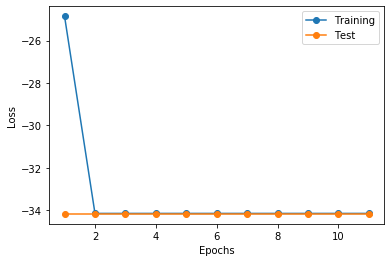

In [50]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation ddataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
plt.xlabel("Epochs"), plt.ylabel("Loss")
# plt.yscale("log")
plt.legend();

# differencwes between the loss for training vs test implies overtraining

In [52]:
prediction = model.predict(X_test)
print(prediction)

[[1.3737751]
 [1.3415366]
 [1.311472 ]
 ...
 [1.4943768]
 [1.4488243]
 [1.3714608]]
